In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


# Datos

## PAES

In [2]:
df_paes = pd.read_excel('../Datos/paes_encrypted.xlsx', skiprows=1) # ruts encriptados
print(df_paes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Nombre      324 non-null    object
 1   RUT         324 non-null    object
 2   Admisión    324 non-null    int64 
 3   C. Lectora  324 non-null    object
 4   Matemática  324 non-null    object
 5   M2          324 non-null    object
 6   Historia    324 non-null    object
 7   Ciencias    324 non-null    object
dtypes: int64(1), object(7)
memory usage: 20.4+ KB
None


## SEPA

In [ ]:
# connection engine using uri
engine = create_engine("")

In [ ]:
# Consulta SQL para calcular el promedio de puntaje por estudiante
sql_str = """
SELECT 
    s.id AS student_id,
    s.fullname AS student_name,
    s.rut AS student_rut,
    ass.name AS test_type,
    ROUND(AVG(a.score), 3) AS average_score
FROM answer a
JOIN student s ON s.id = a.student_id
JOIN question q ON q.id = a.question_id
JOIN assessment ass ON ass.id = q.assessment_id
GROUP BY s.id, ass.name
ORDER BY s.id, ass.name;
"""
df_student_perf = pd.read_sql(sql=sql_text(sql_str), con=engine.connect()) # para versiones mas nuevas de sqlalchemy
df_student_perf.head()

In [5]:
df_student_perf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28138 entries, 0 to 28137
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   student_id     28138 non-null  int64  
 1   student_name   28138 non-null  object 
 2   student_rut    28138 non-null  object 
 3   test_type      28138 non-null  object 
 4   average_score  28138 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.1+ MB


In [4]:
df_student_perf_original = df_student_perf.copy()

In [ ]:
# tenemos filas del tipo: (student_id, student_name, student_rut, test_year_average_score)

# primero creamos una columna para el tipo de prueba y otra para el año
df_student_perf['type'] = df_student_perf['test_type'].apply(lambda x: 1 if 'Len' in x else 0) # 1 es C. Lectora y 0 Matematicas
df_student_perf['year'] = df_student_perf['test_type'].str.extract(r'(\d{4})').astype(int)
df_student_perf.head()

In [ ]:
# mergear df_encrypted (RUT) con df_student_perf (student_rut)
df_perf = df_student_perf.merge(df_paes, left_on='student_rut', right_on='RUT', how='inner')
df_perf.replace('-', np.nan, inplace=True) # reemplazar '-' por NaN (de flojo)
# nos quedamos con las columnas relevantes
df_perf = df_perf[['Nombre', 'student_rut', 'test_type', 'average_score', 'type', 'year']]
df_perf.head(20)

# Graficar

## Lenguaje

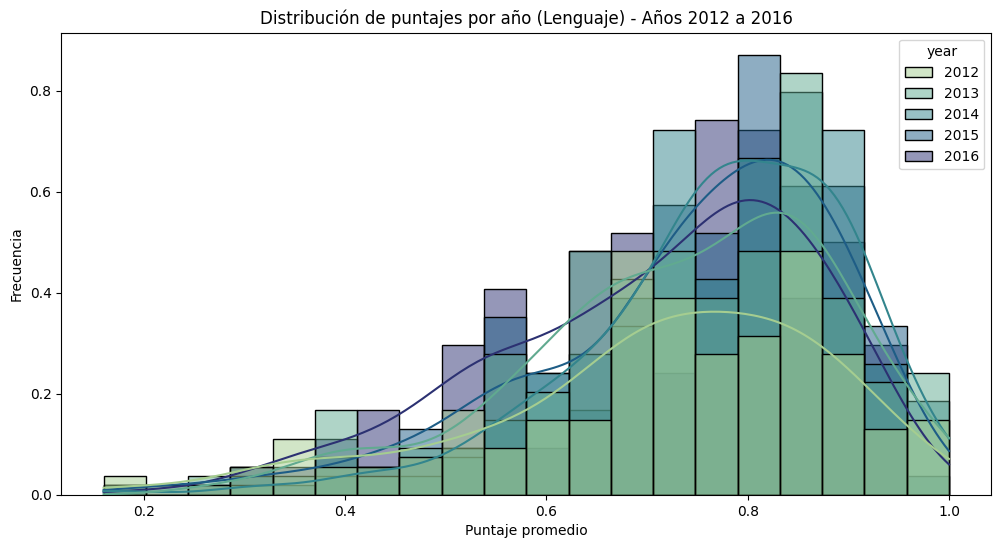

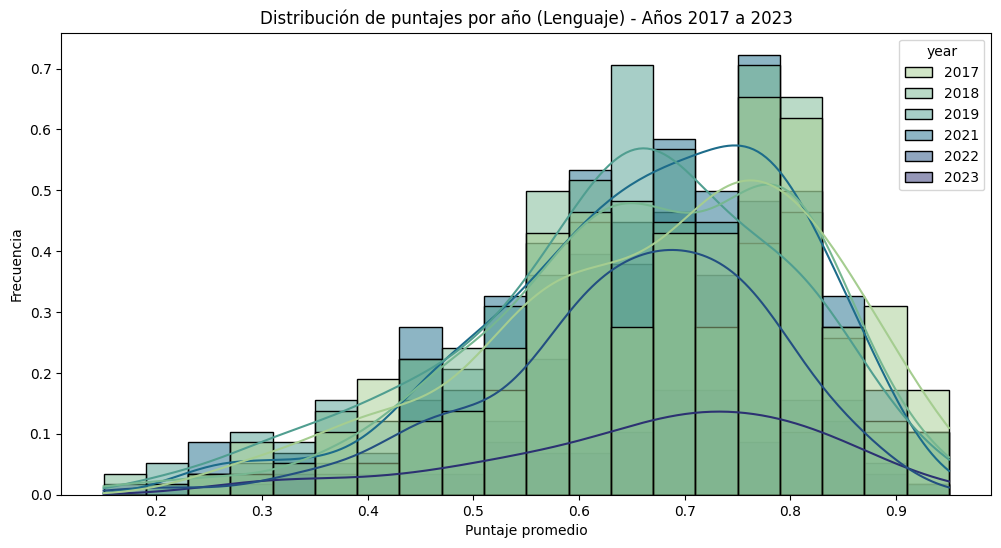

In [8]:
df_pruebas = df_perf[df_perf['type'] == 1]

# graficamos puntajes por año (i.e. distribucion de puntajes por año)
n_figures = 2
# dividimos años en n_figures partes
years = df_pruebas['year'].unique()
years.sort()
n_years = len(years)
years_per_figure = n_years // n_figures
for i in range(n_figures):
    start = i * years_per_figure
    end = (i + 1) * years_per_figure if i < n_figures - 1 else n_years
    years_subset = years[start:end]
    df_subset = df_pruebas[df_pruebas['year'].isin(years_subset)]

    plt.figure(figsize=(12, 6))
    sns.histplot(data=df_subset, x='average_score', hue='year', multiple='layer', bins=20, kde=True, stat='density', palette='crest')
    #plt.axvline(df_subset['average_score'].mean(), color='red', linestyle='--', label='Promedio')
    #plt.axvline(df_subset['average_score'].median(), color='blue', linestyle='--', label='Mediana')
    #plt.axvline(df_subset['average_score'].mode()[0], color='green', linestyle='--', label='Moda')
    plt.title(f'Distribución de puntajes por año (Lenguaje) - Años {years[start]} a {years[end-1]}')
    plt.xlabel('Puntaje promedio')
    plt.ylabel('Frecuencia')
    #plt.legend(title='Año', loc='upper right')
    plt.show()

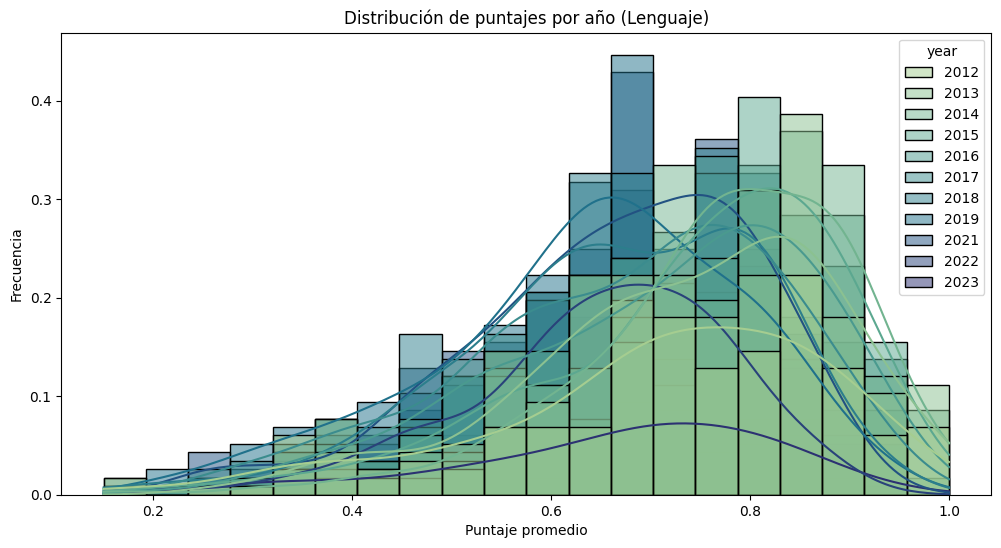

In [9]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_pruebas, x='average_score', hue='year', multiple='layer', bins=20, kde=True, stat='density', palette='crest')
#plt.axvline(df_lenguaje['average_score'].mean(), color='red', linestyle='--', label='Promedio')
#plt.axvline(df_lenguaje['average_score'].median(), color='blue', linestyle='--', label='Mediana')
#plt.axvline(df_lenguaje['average_score'].mode()[0], color='green', linestyle='--', label='Moda')
plt.title('Distribución de puntajes por año (Lenguaje)')
plt.xlabel('Puntaje promedio')
plt.ylabel('Frecuencia')
#plt.legend(title='Año', loc='upper right')
plt.show()

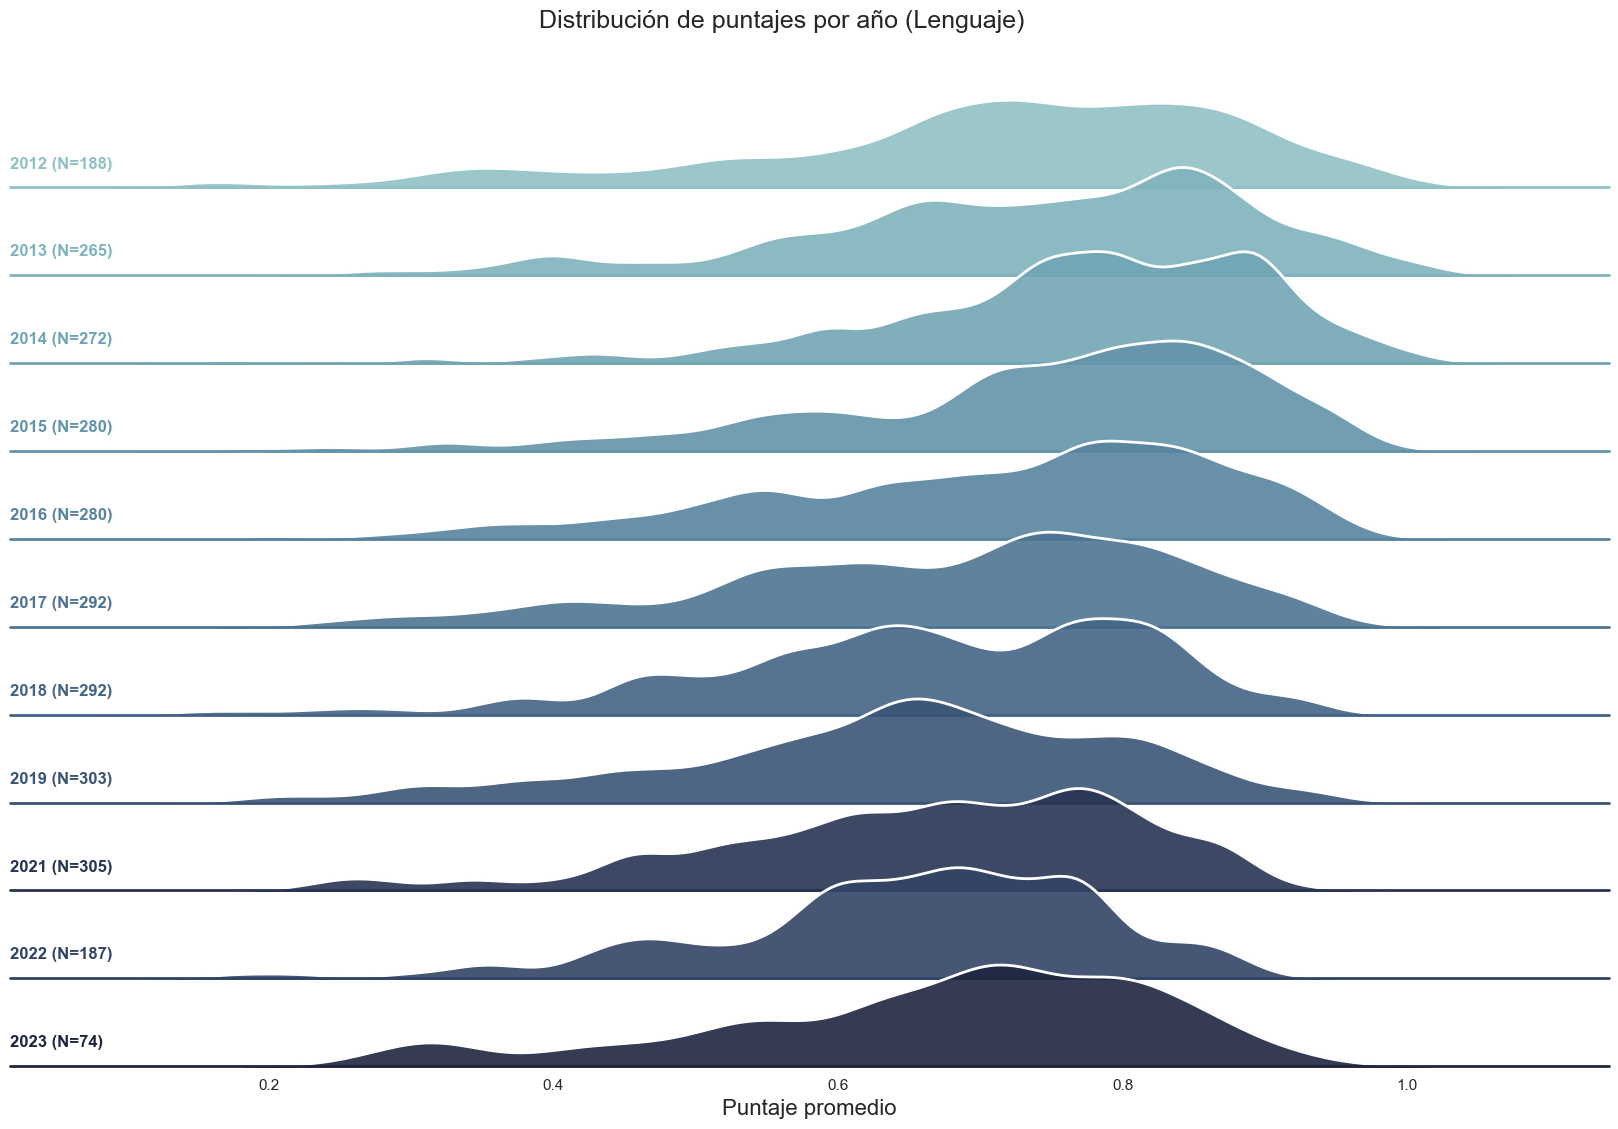

In [10]:
# filtra por tipo de prueba (Lenguaje)
df_mate = df_perf[df_perf['type'] == 1].copy()
# conviertir la columna 'year' a string
df_mate['year'] = df_mate['year'].astype(str)
# ordena los años para el gráfico
years_sorted = sorted(df_mate['year'].unique())

# paleta
pal = sns.cubehelix_palette(len(years_sorted), rot=-.25, light=.7)
# theme
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# crear un FacetGrid con una fila por año y un color por año
g = sns.FacetGrid(
    df_mate,
    row="year",
    hue="year",
    aspect=16.9,      # relación de aspecto horizontal
    height=1,      # altura de cada subgráfico
    palette=pal,    # paleta de colores definida arriba
    row_order=years_sorted  # ordenar las filas por año
)

# plotear en cada subgráfico la densidad de puntajes promedio usando kdeplot
g.map(
    sns.kdeplot,
    "average_score",
    bw_adjust=.5,   
    clip_on=False,  # permite que la curva sobresalga del eje
    fill=True,      
    alpha=0.9,      # opacidad de la curva
    linewidth=1.5   
)

# plotear una segunda curva blanca para casos en que se superpongan las distribuciones
g.map(
    sns.kdeplot,
    "average_score",
    clip_on=False,
    color="w",
    lw=2,
    bw_adjust=.5
)

# plotear una línea de referencia en y=0 para cada subgráfico
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# función para etiquetar cada subgráfico con el año correspondiente
def label(x, color, label):
    ax = plt.gca()
    n = len(x)
    ax.text(
        0, .2, f"{label} (N={n})", fontweight="bold", color=color,
        ha="left", va="center", transform=ax.transAxes
    )
# aplicar la función de etiquetado a cada subgráfico
g.map(label, "average_score")

# ajustar el espacio entre los subgráficos
g.figure.subplots_adjust(hspace=-.25)

# eliminar títulos automáticos y detalles de los ejes
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)


plt.xlabel('Puntaje promedio', fontsize=16)
plt.suptitle('Distribución de puntajes por año (Lenguaje)', fontsize=18, y=1.02)
plt.savefig('../Figuras/Distribucion_puntajes_por_ano_lenguaje.png', dpi=300, bbox_inches='tight')

plt.show()

## Matemáticas

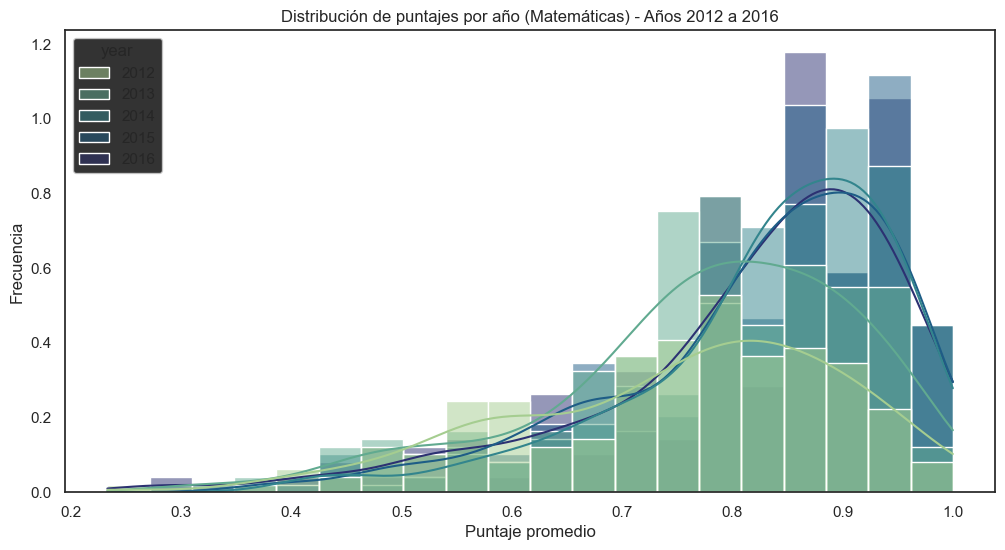

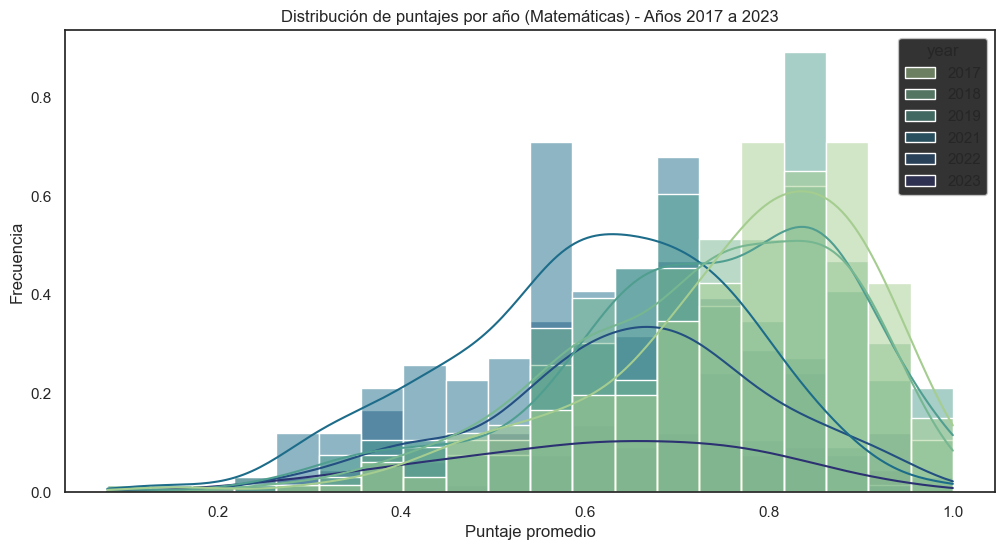

In [12]:
df_pruebas = df_perf[df_perf['type'] == 0]

# graficamos puntajes por año (i.e. distribucion de puntajes por año)
n_figures = 2
# dividimos años en n_figures partes
years = df_pruebas['year'].unique()
years.sort()
n_years = len(years)
years_per_figure = n_years // n_figures
for i in range(n_figures):
    start = i * years_per_figure
    end = (i + 1) * years_per_figure if i < n_figures - 1 else n_years
    years_subset = years[start:end]
    df_subset = df_pruebas[df_pruebas['year'].isin(years_subset)]

    plt.figure(figsize=(12, 6))
    sns.histplot(data=df_subset, x='average_score', hue='year', multiple='layer', bins=20, kde=True, stat='density', palette='crest')
    #plt.axvline(df_subset['average_score'].mean(), color='red', linestyle='--', label='Promedio')
    #plt.axvline(df_subset['average_score'].median(), color='blue', linestyle='--', label='Mediana')
    #plt.axvline(df_subset['average_score'].mode()[0], color='green', linestyle='--', label='Moda')
    plt.title(f'Distribución de puntajes por año (Matemáticas) - Años {years[start]} a {years[end-1]}')
    plt.xlabel('Puntaje promedio')
    plt.ylabel('Frecuencia')
    #plt.legend(title='Año', loc='upper right')
    plt.show()

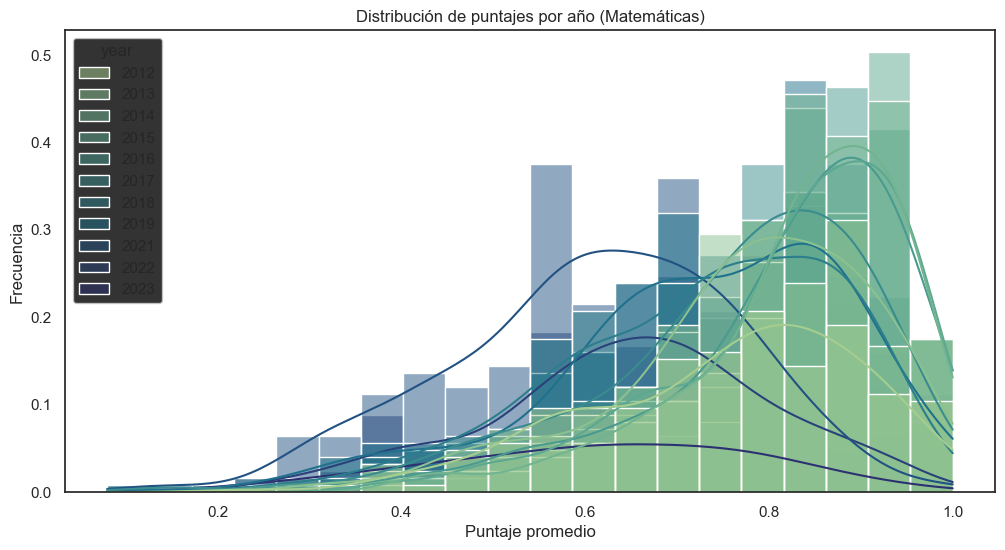

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_pruebas, x='average_score', hue='year', multiple='layer', bins=20, kde=True, stat='density', palette='crest')
#plt.axvline(df_lenguaje['average_score'].mean(), color='red', linestyle='--', label='Promedio')
#plt.axvline(df_lenguaje['average_score'].median(), color='blue', linestyle='--', label='Mediana')
#plt.axvline(df_lenguaje['average_score'].mode()[0], color='green', linestyle='--', label='Moda')
plt.title('Distribución de puntajes por año (Matemáticas)')
plt.xlabel('Puntaje promedio')
plt.ylabel('Frecuencia')
#plt.legend(title='Año', loc='upper right')
plt.show()

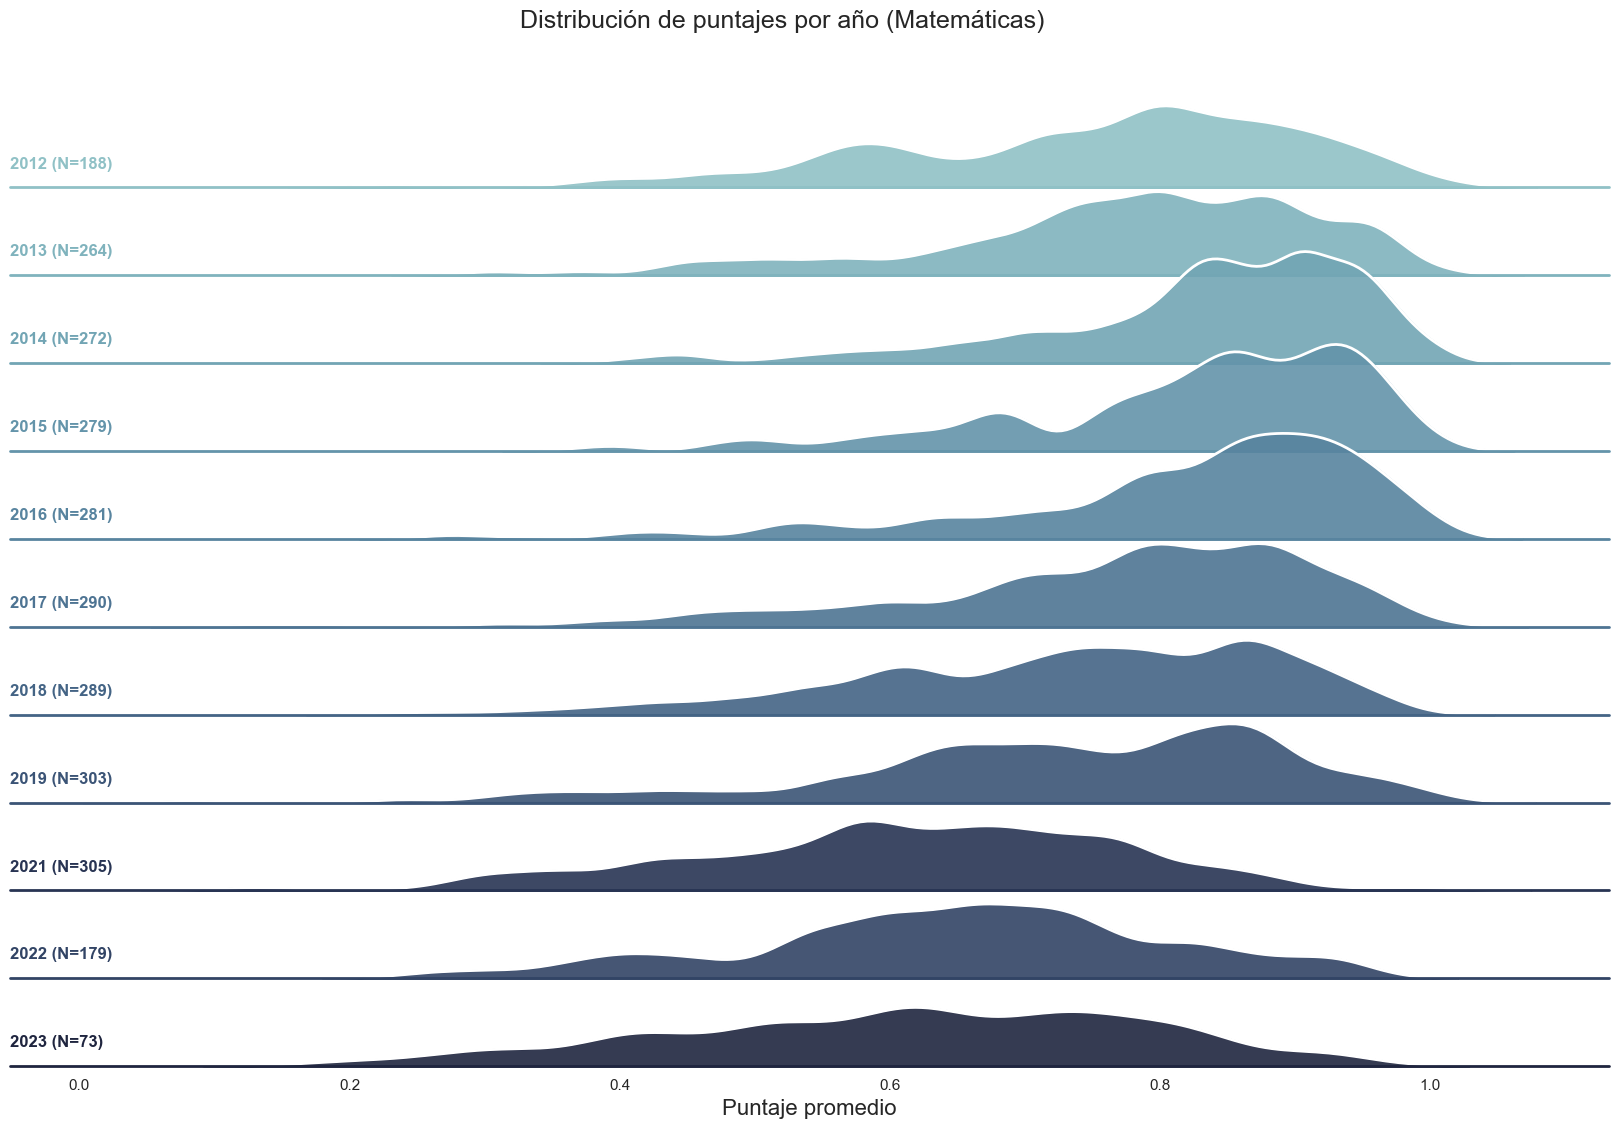

In [14]:
# filtra por tipo de prueba (Matemáticas)
df_mate = df_perf[df_perf['type'] == 0].copy()
# conviertir la columna 'year' a string
df_mate['year'] = df_mate['year'].astype(str)
# ordena los años para el gráfico
years_sorted = sorted(df_mate['year'].unique())

# paleta
pal = sns.cubehelix_palette(len(years_sorted), rot=-.25, light=.7)
# theme
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# crear un FacetGrid con una fila por año y un color por año
g = sns.FacetGrid(
    df_mate,
    row="year",
    hue="year",
    aspect=16.9,      # relación de aspecto horizontal
    height=1,      # altura de cada subgráfico
    palette=pal,    # paleta de colores definida arriba
    row_order=years_sorted  # ordenar las filas por año
)

# plotear en cada subgráfico la densidad de puntajes promedio usando kdeplot
g.map(
    sns.kdeplot,
    "average_score",
    bw_adjust=.5,   
    clip_on=False,  # permite que la curva sobresalga del eje
    fill=True,      
    alpha=0.9,      # opacidad de la curva
    linewidth=1.5   
)

# plotear una segunda curva blanca para casos en que se superpongan las distribuciones
g.map(
    sns.kdeplot,
    "average_score",
    clip_on=False,
    color="w",
    lw=2,
    bw_adjust=.5
)

# plotear una línea de referencia en y=0 para cada subgráfico
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# función para etiquetar cada subgráfico con el año correspondiente
def label(x, color, label):
    ax = plt.gca()
    n = len(x)
    ax.text(
        0, .2, f"{label} (N={n})", fontweight="bold", color=color,
        ha="left", va="center", transform=ax.transAxes
    )
# aplicar la función de etiquetado a cada subgráfico
g.map(label, "average_score")

# ajustar el espacio entre los subgráficos
g.figure.subplots_adjust(hspace=-.25)

# eliminar títulos automáticos y detalles de los ejes
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)


plt.xlabel('Puntaje promedio', fontsize=16)
plt.suptitle('Distribución de puntajes por año (Matemáticas)', fontsize=18, y=1.02)
plt.savefig('../Figuras/Distribucion_puntajes_por_ano_matematicas.png', dpi=300, bbox_inches='tight')

plt.show()